# Fudan RPML Assignment2: Deep Learning Meets News

![news](./news.png)

**Your name and Student ID: [李培基], [20307140044]**

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

In this assignment, you will build a **text classification** system which is a fundamental task in the field of Natural Language Processing (NLP). More precisely, you are given a news classification task, assigning given news texts to the categories to which they belong. Unlike traditional classification tasks, **we did not provide you with any labels for this assignment, and you need to find a way to construct labels for these articles**. 

For this assignment you can use commonly used deep learning frameworks like paddle and pytorch, and **should use at least one kind of deep neural network for this task**. **You can use pretrained word vectors like Glove, but not pretrained large models like BERT.**

# 1. Setup

In [58]:
# setup code
%load_ext autoreload
%autoreload 2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import jieba
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

args = {
    'learning_rate':0.0004, 
    'first_momentum':0.9,
    'second_momentum':0.999,
    'batch_size':128,
    'len_feature':300, # embedding_dim
    'hidden_size':50,
    'dropout':0.5,
    'iter_times':50,
    'num_class':3,
    'train_rate':0.6,
    'dev_rate':0.2,
    'truncated':30,
    'filter_num':100, # CNN卷积核个数 原论文为100(不过原论文是英文数据集)
}
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(f"The current computing device is {device} ")
if torch.cuda.is_available():
    print(f'The current GPU is :{torch.cuda.get_device_name(0)}')
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The current computing device is cuda:5 
The current GPU is :GeForce GTX 1080 Ti


In [31]:
dataset_path = 'assignment2_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)

print(all_data[10343])
print(all_data[78883])
# 明显，这是一个中文新闻标题数据集

什么企业适合开展融资租赁业务？你不看，真的吃大亏了！
你见过苗寨里待客的方式吗？网友调侃：这才是真正的不醉不归啊！


# 2. Exploratory Data Analysis (5 points)

数据集句子总数 83360
数据集字符最长/最短长度: 145 / 2
数据集中最长字符的句子:
 【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓
数据集中最短字符的句子:
 美国
数据集中句子字符长度平均值: 22.235280710172745
数据集中句子字符长度超过 50 的句子数目: 66 / 83360
因此结合句子长度分布图，我们有理由在后续处理时对句子长度进行截取


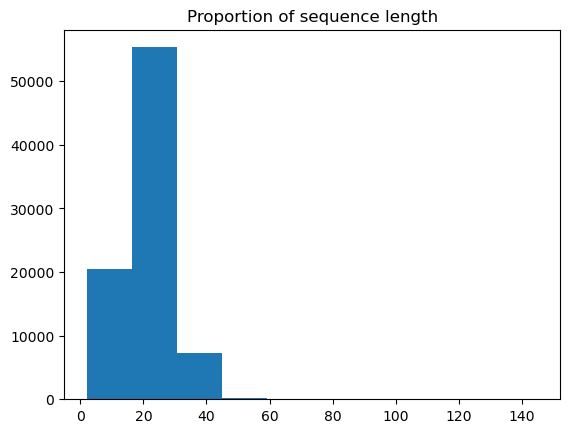

In [32]:
%matplotlib inline
print('数据集句子总数',len(all_data))
min_len = 9999
max_len = 0
id_1 = -1
id_2 = -1
len_list = []
for idx,sentence in enumerate(all_data,0):
    l = len(sentence)
    if l > max_len:
        max_len = l
        id_1 = idx
    if l < min_len:
        min_len = l
        id_2 = idx
    len_list.append(l)
print('数据集字符最长/最短长度:',max_len,'/',min_len)
print('数据集中最长字符的句子:\n',all_data[id_1])
print('数据集中最短字符的句子:\n',all_data[id_2])
print('数据集中句子字符长度平均值:',sum(len_list)/len(len_list))
print('数据集中句子字符长度超过 50 的句子数目:',sum(np.array(len_list) > 50),'/',len(all_data))
print('因此结合句子长度分布图，我们有理由在后续处理时对句子长度进行截取')
plt.title('Proportion of sequence length')
plt.hist(len_list)
plt.show()

In [33]:
# 尝试jieba分词效果
import jieba
seg_list = jieba.cut("【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓")  # 默认是精确模式
print(seg_list)
print(" ".join(seg_list))
seg_list = jieba.lcut("【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓")
print(seg_list) 

<generator object Tokenizer.cut at 0x7f3d112e5c00>
【 定 了 ！ 中日 双方 签署 有关 经贸合作 协议 】 5 月 9 日 ， 在 李克强 总理 和 安倍晋三 首相 共同 见证 下 ， 中国 商务部 钟山 部长 与 日本 经济 产业 大臣 世耕弘成 共同 签署 了 《 关于 加强 服务 贸易 合作 的 备忘录 》 ， 中国 国家 发展 改革 委 、 商务部 与 日本外务省 、 经济 产业省 共同 签署 了 《 关于 中日 第三方 市场 合作 的 备忘录 》 。 详细 内容 ， 请 戳 大图 ↓
['【', '定', '了', '！', '中日', '双方', '签署', '有关', '经贸合作', '协议', '】', '5', '月', '9', '日', '，', '在', '李克强', '总理', '和', '安倍晋三', '首相', '共同', '见证', '下', '，', '中国', '商务部', '钟山', '部长', '与', '日本', '经济', '产业', '大臣', '世耕弘成', '共同', '签署', '了', '《', '关于', '加强', '服务', '贸易', '合作', '的', '备忘录', '》', '，', '中国', '国家', '发展', '改革', '委', '、', '商务部', '与', '日本外务省', '、', '经济', '产业省', '共同', '签署', '了', '《', '关于', '中日', '第三方', '市场', '合作', '的', '备忘录', '》', '。', '详细', '内容', '，', '请', '戳', '大图', '↓']


# 3. Construct the Labels (40 points)

## 3.1 average_word_embedding + K-means聚类
1. 首先利用jieba分词，去除只有一个词的文本，并去除中文停用词，获得分词后的文本数据集
2. 之后使用预训练的word_vector标注每一个句子中的单词，然后对这些单词向量取平均，获得每个句子的sentence_embedding，最后再进行K-means聚类，将数据集中的句子无监督的进行分类。


In [34]:
# 加载预训练的word_embedding [365076,300]
# sgns.sogounews.bigram-char sgns.sogou.char
with open('sgns.sogou.char','rb') as f:
    lines = f.readlines()
    
trained_dict = dict()
n = len(lines)  # 为预训练文件总行数
embedding_dim = len(lines[1].split())-1
for i in range(1,n):
    # 因为第一行不是数据 共365076的词/字 每个被映射到300维空间
    line = lines[i].split()
    trained_dict[line[0].decode('utf-8')] = [float(line[j]) for j in range(1,embedding_dim+1)]

In [35]:
# 用jieba 进行中文分词
data = []
for sentence in all_data:
    seg_list = [w for w in jieba.cut(sentence) if len(w) > 1]
    if len(seg_list) > 1 and seg_list != '\r\t':
        data.append(seg_list)
#停用词加载
stopwords = pd.read_table('stopwords.txt',names = ['stopword'],quoting = 3)

df_content = pd.DataFrame({'data':data})
#去除停用词
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(word)
        contents_clean.append(line_clean)
    return contents_clean,all_words

data = df_content.data.values.tolist()

In [36]:
# 使用中文分词后 数据集句子的长度分析
print('数据集句子总数',len(data))
min_len = 9999
max_len = 0
id_1 = -1
id_2 = -1
len_list = []
for idx,sentence in enumerate(data,0):
    l = len(sentence)
    if l > max_len:
        max_len = l
        id_1 = idx
    if l < min_len:
        min_len = l
        id_2 = idx
    len_list.append(l)
print('数据集最长/最短长度:',max_len,'/',min_len)
print('数据集中最多词的句子:\n',data[id_1])
print('数据集中最少词的句子:\n',data[id_2])
print('数据集中词长度长度平均值:',sum(len_list)/len(len_list))
print('数据集中词数量超过 30 的句子数目:',sum(np.array(len_list) > 30),'/',len(data))

数据集句子总数 83175
数据集最长/最短长度: 48 / 2
数据集中最多词的句子:
 ['中日', '双方', '签署', '有关', '经贸合作', '协议', '李克强', '总理', '安倍晋三', '首相', '共同', '见证', '中国', '商务部', '钟山', '部长', '日本', '经济', '产业', '大臣', '世耕弘成', '共同', '签署', '关于', '加强', '服务', '贸易', '合作', '备忘录', '中国', '国家', '发展', '改革', '商务部', '日本外务省', '经济', '产业省', '共同', '签署', '关于', '中日', '第三方', '市场', '合作', '备忘录', '详细', '内容', '大图']
数据集中最少词的句子:
 ['都江堰', '景区']
数据集中词长度长度平均值: 7.518352870453862
数据集中词数量超过 30 的句子数目: 5 / 83175


In [37]:
import torch
class Embedding():
    def __init__(self,trained_dict,data,args) -> None:
        self.dict_words = {}    # 单词映射到自然数的字典
        self.sentence_matrix = []   # 数据集中句子的矩阵表示（每个词为一个自然数）
        self.embedding_matrix = [] # embedding矩阵，每个word_vector对应的下标id为相应的词
        self.trained_dict = trained_dict  # 预训练的词典：词与word_vector的对应
        self.embedding_dim = args['len_feature'] # embedding dim
        self.data = data # 分词后的数据集
        self.sentence_vector = [] # 数据集每个句子的向量表示(sentence embedding)
        self.labels = None
    
    def get_words(self):
        '''
        此函数的目标是建立单词与自然数的映射的词典,同时建立好embedding_weight矩阵,并不处理数据集
        '''
        self.embedding_matrix.append([0]*self.embedding_dim) # [PAD] id:0
        self.embedding_matrix.append([0]*self.embedding_dim) # [UNK] id:1
        self.dict_words['[PAD]'] = 0
        self.dict_words['[UNK]'] = 1
        for word in self.trained_dict.keys():
            if word not in self.dict_words:
                self.dict_words[word] = len(self.dict_words) + 2
                self.embedding_matrix.append(self.trained_dict[word])
        mean = torch.mean(torch.tensor(self.embedding_matrix))
        std = torch.std(torch.tensor(self.embedding_matrix))
        unknown_vec = torch.normal(mean,std,size = [1,self.embedding_dim]).reshape(-1)
        self.embedding_matrix[1] = unknown_vec.tolist()    # for [UNK]： Gaussian Sample 有的论文做法
    
    def get_id(self):
        '''
        这个函数目的是给数据集中的句子建立成矩阵，每个句子表示为一串id，对应着 embedding矩阵的 下标
        '''
        for sentence in self.data:
            item = []
            for word in sentence:
                if word not in self.dict_words:
                    item.append(self.dict_words['[UNK]'])
                else:
                    item.append(self.dict_words[word])
            self.sentence_matrix.append(item)
    
    def average_sen2vec(self):
        '''
        此函数的目标是做一个sentence_embedding,即sen2vec
        '''
        for sentence in self.sentence_matrix:
            sum_vec = np.array([0.0]*self.embedding_dim,dtype = 'float32')
            sentence_length = len(sentence)
            for idx in sentence:
                word_vec = np.array(self.embedding_matrix[idx],dtype = 'float32')
                sum_vec = sum_vec + word_vec
            self.sentence_vector.append( (sum_vec/sentence_length).tolist() )
            

In [38]:
ebd = Embedding(trained_dict=trained_dict,data=data,args=args)
ebd.get_words()
ebd.get_id()

In [39]:
ebd.average_sen2vec()

In [40]:
m = ebd.sentence_vector


In [41]:
# 此部分仅是实验一下效果
from sklearn.cluster import KMeans
import numpy as np
X = np.array(m)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
news_data = []
for idx,sentence in enumerate(data,0):
    item = [sentence] + [kmeans.labels_[idx]]
    news_data.append(item)

In [42]:
# 我们测试一下分类效果
print(len(news_data))
for i in range(200):
    s = news_data[i][1]
    if s == 0:
        print(news_data[i])

83175
[['经济学家', '吴敬琏', '为什么', '反对', '不惜代价', '发展', '芯片', '产业'], 0]
[['如何', '评价', '许鞍华', '导演', '电影', '为什么', '总能', '给人以', '触动'], 0]
[['规划', '公示', '苏州', '古城区', '变化'], 0]
[['放任', '台独', '叫嚣', '英文', '戳破', '现状'], 0]
[['方舟子', '象棋', '源自', '印度', '中国', '古代', '没有', '大象', '认为', '这种', '说法', '怎么样'], 0]
[['高考', '志愿', '影响', '未来'], 0]
[['2018', '航天', '领域', '发生', '哪些', '期待'], 0]
[['古希腊', '众神', '那点', '事儿'], 0]
[['缅甸', '人民', '云南', '瑞丽', '幸福生活'], 0]
[['为什么', '股东', '人数', '大幅', '减少', '筹码', '更为', '集中', '股票', '一直', '下跌'], 0]
[['郭德纲', '恩师', '侯耀文', '出身', '名门', '一生', '显赫', '死后', '四年', '得以', '入土为安'], 0]
[['农产品', '怎么', '才能', '赚大钱', '大家', '过来'], 0]
[['智能', '制造', '产业园', '落户', '高新区'], 0]
[['夏普', '推出', '机器人', '手机', '售价', '11000', '人民币', '功能齐全', '长得', '很萌'], 0]
[['2018', '巴西', '大豆', '产量', '历史', '纪录', '中国', '买家', '好消息'], 0]
[['月份', '巴中', '城区', '鲜菜', '价格', '降幅', '收窄'], 0]
[['广东', '哪个', '地方', '茶叶', '出名'], 0]
[['美国', '生活', '怎么', '公寓'], 0]
[['美丽', '乡村', '温州'], 0]
[['潜伏', '蒋介石', '身边', '女特工', '凭借', '特殊', '能力', '重用', '后来', '结局', 

In [43]:
print(kmeans.labels_[0:20])
print(data[0:20])


[0 1 2 2 0 0 0 0 2 0 1 0 0 2 2 0 0 2 0 0]
[['经济学家', '吴敬琏', '为什么', '反对', '不惜代价', '发展', '芯片', '产业'], ['颜值', '一双', '美腿', '甚至', '可以', '忽略', '颜值'], ['转自', '常德', '诗人', '再访', '桃花源', '再续', '心灵', '故乡', '故事'], ['虎牙', '拼杀', '四年', '游戏', '直播', '第一股', '真正', '挑战', '才刚', '开始'], ['如何', '评价', '许鞍华', '导演', '电影', '为什么', '总能', '给人以', '触动'], ['规划', '公示', '苏州', '古城区', '变化'], ['放任', '台独', '叫嚣', '英文', '戳破', '现状'], ['方舟子', '象棋', '源自', '印度', '中国', '古代', '没有', '大象', '认为', '这种', '说法', '怎么样'], ['徐小平', '投资', '100%', '看人', '创业者', '见面', '马上', '给钱'], ['高考', '志愿', '影响', '未来'], ['小米', 'mix2', 'vivox21', 'oppor15', '哪个', '性价比'], ['2018', '航天', '领域', '发生', '哪些', '期待'], ['古希腊', '众神', '那点', '事儿'], ['上联', '一生', '二生', '三生', '万物', '物物', '生辉', '怎么', '下联'], ['猪八戒', '为啥', '真武大帝', '不怕', '自吹', '不敢'], ['缅甸', '人民', '云南', '瑞丽', '幸福生活'], ['为什么', '股东', '人数', '大幅', '减少', '筹码', '更为', '集中', '股票', '一直', '下跌'], ['现金', '农村', '中小学', '教师', '三十年', '教龄', '荣誉证书', '你会选', '一个'], ['郭德纲', '恩师', '侯耀文', '出身', '名门', '一生', '显赫', '死后', '四年', '得以', '入土为安'], 

## 3.2 LDA主题模型
LDA 主题模型又称隐性狄利克雷模型，是由2003的一篇论文 Latent Dirichlet Allocation提出，作者是 Blei D M, Ng A Y, Jordan M I，其中就有吴恩达老师。是一种无监督的用于将文档分类的机器学习方法，能够为每个主题生成关键词权重，同时可以给出一篇文档属于各个主题的的概率。

1. 利用jieba分词，去除只有一个词的文本，并去除中文停用词，获得分词后的文本数据集
2. 利用LDA模型将文本分类，因为得到主题都具有可解释性(具有关键词)，我们直接取每个文本具有最大概率的主题作为该条文本的标签，而不再进行聚类方法。

In [44]:
class Embedding():
    def __init__(self,trained_dict,data,args) -> None:
        self.dict_words = {}    # 单词映射到自然数的字典
        self.sentence_matrix = []   # 数据集中句子的矩阵表示（每个词为一个自然数）
        self.embedding_matrix = [] # embedding矩阵，每个word_vector对应的下标id为相应的词
        self.trained_dict = trained_dict  # 预训练的词典：词与word_vector的对应
        self.embedding_dim = args['len_feature'] # embedding dim
        self.data = data # 分词后的数据集
        self.sentence_vector = [] # 数据集每个句子的向量表示(sentence embedding)
        self.labels = None
    
    def get_words(self):
        '''
        此函数的目标是建立单词与自然数的映射的词典,同时建立好embedding_weight矩阵,并不处理数据集
        '''
        self.embedding_matrix.append([0]*self.embedding_dim) # [PAD] id:0
        self.embedding_matrix.append([0]*self.embedding_dim) # [UNK] id:1
        self.dict_words['[PAD]'] = 0
        self.dict_words['[UNK]'] = 1
        for word in self.trained_dict.keys():
            if word not in self.dict_words:
                self.dict_words[word] = len(self.dict_words) + 2
                self.embedding_matrix.append(self.trained_dict[word])
        mean = torch.mean(torch.tensor(self.embedding_matrix))
        std = torch.std(torch.tensor(self.embedding_matrix))
        unknown_vec = torch.normal(mean,std,size = [1,self.embedding_dim]).reshape(-1)
        self.embedding_matrix[1] = unknown_vec.tolist()    # for [UNK]： Gaussian Sample 有的论文做法
    
    def get_id(self):
        '''
        这个函数目的是给数据集中的句子建立成矩阵，每个句子表示为一串id，对应着 embedding矩阵的 下标
        '''
        for sentence in self.data:
            item = []
            for word in sentence:
                if word not in self.dict_words:
                    item.append(self.dict_words['[UNK]'])
                else:
                    item.append(self.dict_words[word])
            self.sentence_matrix.append(item)
    
    def average_sen2vec(self):
        '''
        此函数的目标是做一个sentence_embedding,即sen2vec
        '''
        for sentence in self.sentence_matrix:
            sum_vec = np.array([0.0]*self.embedding_dim,dtype = 'float32')
            sentence_length = len(sentence)
            for idx in sentence:
                word_vec = np.array(self.embedding_matrix[idx],dtype = 'float32')
                sum_vec = sum_vec + word_vec
            self.sentence_vector.append( (sum_vec/sentence_length).tolist() )
    
    def get_labels(self,labels):
        self.labels = labels
        if len(labels) != len(self.data):
            raise Exception('标签数量与数据集数量不相符')

In [45]:
with open('sgns.sogou.char','rb') as f:
    lines = f.readlines()
    
trained_dict = dict()
n = len(lines)  # 为预训练文件总行数
embedding_dim = len(lines[1].split())-1

for i in range(1,n):
    # 因为第一行不是数据 共365076的词/字 每个被映射到300维空间
    line = lines[i].split()
    trained_dict[line[0].decode('utf-8')] = [float(line[j]) for j in range(1,embedding_dim+1)]
dataset_path = 'assignment2_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)
content = all_data

In [46]:
#分词
content_S = []
for line in content:
    current_segment = [w for w in jieba.cut(line) if len(w) > 1] # 分词
    if len(current_segment) > 1 and current_segment != '\r\t':
        content_S.append(current_segment)
#分词结果转为DataFrame
df_content = pd.DataFrame({'content_S':content_S})

#停用词加载
stopwords = pd.read_table('stopwords.txt',names = ['stopword'],quoting = 3)

#去除停用词
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(word)
        contents_clean.append(line_clean)
    return contents_clean,all_words

contents = df_content.content_S.values.tolist()
stopwords = stopwords.stopword.values.tolist()
#contents_clean存储的是一个文本处理结果一个数组，all_words是将所有文本处理结果存储为1个数组
contents_clean,all_words = drop_stopwords(contents,stopwords)

#处理后的结果转化为DataFrame
df_content = pd.DataFrame({'contents_clean':contents_clean})#文本处理结果
df_all_words = pd.DataFrame({'all_words':all_words})#语料词典

#统计语料词典中的词出现频率
words_count = df_all_words.groupby(by=['all_words'])['all_words'].agg([('count',np.size)])
words_count = words_count.reset_index().sort_values(by=['count'],ascending = False)#降序


from gensim import corpora,models,similarities
import gensim

dictionary = corpora.Dictionary(contents_clean)
corpus = [dictionary.doc2bow(sentence) for sentence in contents_clean]
lda = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=3,random_state=1)

labels = []

print(lda.print_topics(num_topics=3,num_words=10))
#预测文本的主题
for e, values in enumerate(lda.inference(corpus)[0]):
    # print(contents[e])
    max_value = -1
    label = -1
    for ee, value in enumerate(values):
        # print('\t主题%d推断值%.2f' % (ee, value))
        if value > max_value:
            max_value = value
            label = int(ee)
    labels.append(label)


[(0, '0.006*"上联" + 0.006*"下联" + 0.005*"手机" + 0.003*"看待" + 0.003*"王者" + 0.003*"荣耀" + 0.003*"游戏" + 0.003*"小米" + 0.003*"上市" + 0.003*"英雄"'), (1, '0.006*"网友" + 0.006*"农村" + 0.004*"知道" + 0.003*"孩子" + 0.003*"没有" + 0.003*"真的" + 0.003*"故事" + 0.003*"生活" + 0.003*"活动" + 0.002*"需要"'), (2, '0.019*"中国" + 0.012*"美国" + 0.007*"世界" + 0.005*"现在" + 0.005*"2018" + 0.004*"日本" + 0.004*"国家" + 0.004*"俄罗斯" + 0.003*"发展" + 0.003*"伊朗"')]


In [47]:
# 测试一下分类效果
# 分三类： 文娱看点 社会民生 国际时事
for i in range(200):
    if labels[i] == 2:
        print(contents[i])

['经济学家', '吴敬琏', '为什么', '反对', '不惜代价', '发展', '芯片', '产业']
['转自', '常德', '诗人', '再访', '桃花源', '再续', '心灵', '故乡', '故事']
['放任', '台独', '叫嚣', '英文', '戳破', '现状']
['2018', '航天', '领域', '发生', '哪些', '期待']
['缅甸', '人民', '云南', '瑞丽', '幸福生活']
['为什么', '股东', '人数', '大幅', '减少', '筹码', '更为', '集中', '股票', '一直', '下跌']
['农产品', '怎么', '才能', '赚大钱', '大家', '过来']
['2018', '巴西', '大豆', '产量', '历史', '纪录', '中国', '买家', '好消息']
['伊拉克', '战争', '十二张', '照片', '战争', '面前', '任何人', '渺小']
['一年级', '下册', '语文', '考试', '复习', '重点', '什么']
['民宿', '发展', '乡村', '旅游业', '发展', '必要', '联系']
['最具', '特色', '十大', '古村落', '中国', '才能', '看到', '绝无仅有']
['如果', '日本', '国土', '滑向', '海沟', '沉没', '要求', '中国', '人民', '收留', '作为', '中国', '接受', '日本']
['嘴仗', '结束', '伊朗', '局势', '升级', '中东', '热战', '开始', '美国', '为何', '积极', '点赞']
['磷酸', '价格', '大幅', '下跌', '相关', '上市公司', '承压', '明显', '影响']
['国内', '四款', '主要', '牵引车', '模型', '简单', '对比']
['魔鬼', '任用', '氨水', '女友', '双眼', '兜风', '痛久点']
['巴厘岛', '旅游', '是否', '见到']
['军事', '美国', '海军', '最新型', '高速', '双体船', '海上', '测试']
['为什么', '歌曲', '日语', '填词', '容易']
['上海', '孟买'

In [48]:
# 实例化Embedding类，并且为文本打上标签
ebd = Embedding(trained_dict=trained_dict,data=contents,args=args)
ebd.get_words()
ebd.get_id()
ebd.get_labels(labels)

## 3.3 对比与总结
我们尝试了两种无监督分类方法，虽然两种分类都存在一些文本被不正确的归为一类，但考虑到完全无监督没有经过训练的情况下，两种方法都展现了一定的效果。最终我们认为LDA模型更具有可解释性，且分类效果更好一些。因此我们最后采取LDA模型为文本建立标签，可以分为三类，根据模型筛选出高权重词向量，我们可以发现这三类正好对应“文娱看点 社会民生 国际时事”三种标签

# 4. News Classification (50 points)

## 4.1 数据集预处理和划分

In [49]:
class Initial_Embedding():
    def __init__(self,ebd,args) -> None:
        self.dict_words = ebd.dict_words    # 单词映射到自然数的字典 ，包括了[PAD] [UNK]
        self.trained_dict = ebd.trained_dict  # 下载的预训练的词典：词与word_vector的对应，未做更多处理
        self.embedding_matrix = ebd.embedding_matrix # word embedding矩阵，每个word_vector对应的下标id为相应的词
        self.embedding_dim = args['len_feature'] # embedding dim : 300
        self.data = ebd.data # 分词后的总数据集
        self.labels = ebd.labels
        self.sentence_matrix = ebd.sentence_matrix   # 数据集中句子的矩阵表示（每个词为一个自然数）
        self.train = None
        self.dev = None
        self.test = None
        self.train_y = None
        self.dev_y = None
        self.test_y = None
        
        for idx in range(len(self.data)):
            if len(self.data[idx]) > args['truncated']:
                self.data[idx] = self.data[idx][0:args['truncated']]
    
    def data_split(self,args = args):
        num = len(self.data)
        train_num = int(num * args['train_rate'])
        dev_num = int(num * args['dev_rate'])
        self.train = self.sentence_matrix[0:train_num]
        self.dev = self.sentence_matrix[train_num:train_num + dev_num]
        self.test = self.sentence_matrix[train_num + dev_num:]
        self.train_y = self.labels[0:train_num]
        self.dev_y = self.labels[train_num:train_num + dev_num]
        self.test_y = self.labels[train_num + dev_num:]



In [50]:
embedding = Initial_Embedding(ebd=ebd,args=args)
embedding.data_split(args)

In [51]:
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence

class ClsDataset(Dataset):
    def __init__(self,sentence,labels):
        super(ClsDataset,self).__init__()
        self.sentence = sentence
        self.labels = labels
    
    def __getitem__(self,index):
        return self.sentence[index],self.labels[index]
    
    def __len__(self):
        return len(self.sentence)

train_set = ClsDataset(sentence=embedding.train,labels = embedding.train_y)
dev_set = ClsDataset(sentence=embedding.dev,labels = embedding.dev_y)
test_set = ClsDataset(sentence=embedding.test,labels=embedding.test_y)

def collate_fn(batch_data):
    sentence, labels = zip(*batch_data)
    sentences = [torch.LongTensor(sent) for sent in sentence]  # 把句子变成Longtensor类型
    valid_lens = [len(sent) for sent in sentence]
    padded_sents = pad_sequence(sentences, batch_first=True, padding_value=0)  # 自动padding操作！！！
    return torch.LongTensor(padded_sents).to(device), torch.LongTensor(labels).to(device),torch.LongTensor(valid_lens).to(device)

'''
此处有以下需要注意：
>>> from torch.nn.utils.rnn import pad_sequence
>>> a = torch.ones(25, 300)
>>> b = torch.ones(22, 300)
>>> c = torch.ones(15, 300)
>>> pad_sequence([a, b, c],batch_first = True).size()
>>> [3,25,300]
    我按照自己习惯，使用batch_first = True
    打包一个batch返回 [B,L,M] = [batch_size,seq_length(after_padding),len_feature]
    在 RNN 中 可以直接用
    在 CNN 中 需要扩展维度为 [B,channel=1,L,M], 以符合卷积层输入 
'''

train_loader = DataLoader(train_set,batch_size = args['batch_size'],shuffle=False,drop_last=True,collate_fn=collate_fn)
dev_loader = DataLoader(dev_set,batch_size = args['batch_size'],shuffle=False,drop_last=True,collate_fn=collate_fn)
test_loader = DataLoader(test_set,batch_size = args['batch_size'],shuffle=False,drop_last=True,collate_fn=collate_fn)

## 4.2 CNN
此部分参考了论文 Convolutional Neural Networks for Sentence Classification https://arxiv.org/abs/1408.5882

![jupyter](./CNNClf.png)

使用卷积神经网络，同时利用几组不同大小的卷积核提取特征+最大池化+拼接的方法，结合目的是提取句子中临近词组的语义特征

In [52]:
from fudanPRML.model import CNNModel
from fudanPRML.plot import plot
from fudanPRML.runner import Runner_V1
model = CNNModel(args=args,init_embedding=embedding)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003) 
runner = Runner_V1(model = model,optimizer=optimizer,loss_fn = loss_fn)


In [53]:
runner.train(train_loader,dev_loader)

Best performance on valid set upgraded: accuracy: 0.3574975775193798
Best performance on valid set upgraded: accuracy: 0.37415213178294576
Best performance on valid set upgraded: accuracy: 0.3963178294573643
[epoch]:1,[step]:10,[loss]:1.0921250581741333,[score]:0.3984375
Best performance on valid set upgraded: accuracy: 0.40394864341085274
Best performance on valid set upgraded: accuracy: 0.4097625968992248
Best performance on valid set upgraded: accuracy: 0.4364704457364341
Best performance on valid set upgraded: accuracy: 0.4410125968992248
[epoch]:1,[step]:20,[loss]:1.0190629959106445,[score]:0.4921875
Best performance on valid set upgraded: accuracy: 0.44949127906976744
Best performance on valid set upgraded: accuracy: 0.4498546511627907
[epoch]:1,[step]:30,[loss]:1.0957303047180176,[score]:0.4453125
Best performance on valid set upgraded: accuracy: 0.459484011627907
Best performance on valid set upgraded: accuracy: 0.46184593023255816
Best performance on valid set upgraded: accura

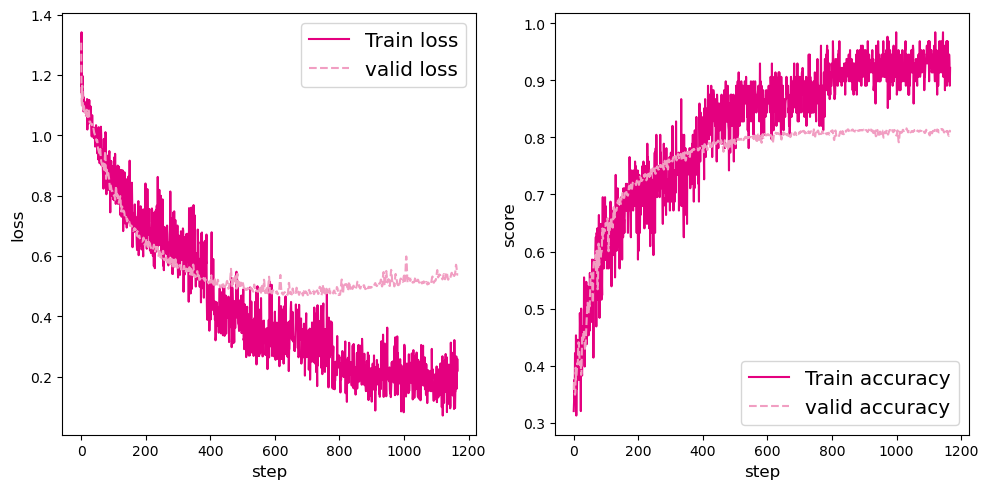

In [54]:
plot(runner,fig_name='CNN_Classifier.pdf')

In [55]:
runner.predict(test_loader)

Score on test set:0.8062015503875969


0.8062015503875969

## 4.3 RNN(Bi-LSTM)
使用两层双向LSTM模型，结合dropout方法训练模型。

取LSTM最后一层的最后一个输出向量(最终隐藏层状态),输入线性分类器中用于分类

In [59]:
from fudanPRML.model import BiLSTM_Model_V1
from fudanPRML.plot import plot
from fudanPRML.runner import Runner_V1
model = BiLSTM_Model_V1(args=args,init_embedding = embedding,num_layers = 1)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003) 
runner = Runner_V1(model = model,optimizer=optimizer,loss_fn = loss_fn)

In [60]:
runner.train(train_loader,dev_loader)

Best performance on valid set upgraded: accuracy: 0.3583454457364341
Best performance on valid set upgraded: accuracy: 0.38099563953488375
Best performance on valid set upgraded: accuracy: 0.38196463178294576
Best performance on valid set upgraded: accuracy: 0.4015261627906977
Best performance on valid set upgraded: accuracy: 0.40618943798449614
Best performance on valid set upgraded: accuracy: 0.4147892441860465
[epoch]:1,[step]:10,[loss]:1.070370078086853,[score]:0.4453125
Best performance on valid set upgraded: accuracy: 0.4272044573643411
Best performance on valid set upgraded: accuracy: 0.42914244186046513
Best performance on valid set upgraded: accuracy: 0.4367732558139535
Best performance on valid set upgraded: accuracy: 0.45591085271317827
[epoch]:1,[step]:20,[loss]:1.0214182138442993,[score]:0.5
Best performance on valid set upgraded: accuracy: 0.4660247093023256
Best performance on valid set upgraded: accuracy: 0.4679626937984496
Best performance on valid set upgraded: accura

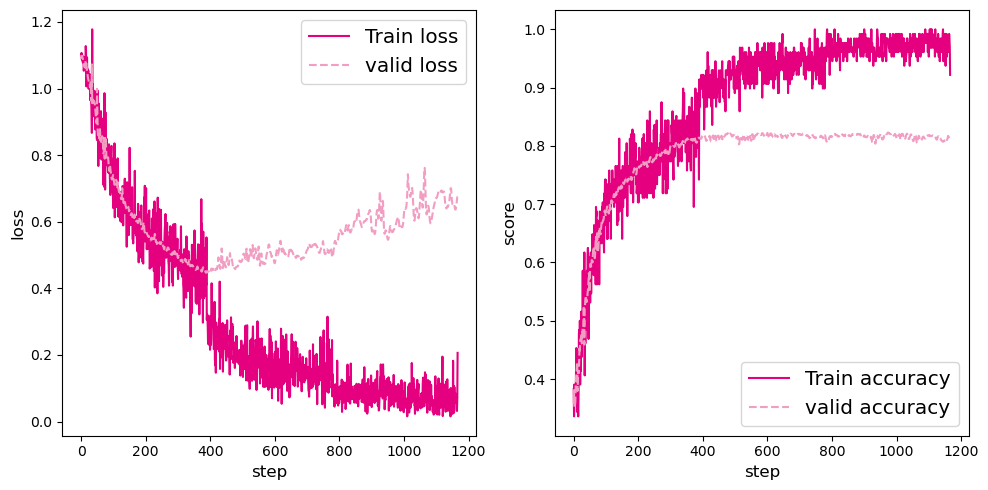

In [61]:
plot(runner,fig_name='Bi-LSTM_V1.pdf')

In [62]:
runner.predict(test_loader)

Score on test set:0.8129239341085271


0.8129239341085271

## 4.4 Bi-LSTM + Multihead-self-attention + Average_pooling


1. 嵌入层：将输入句子中的词语转换为向量表示；

2. LSTM层：基于双向LSTM网络来建模句子中词语的上下文表示；

3. 自注意力层：使用多头自注意力机制来计算LSTM的自注意力特征表示；

4. 汇聚层：对多头自注意力的输出进行平均汇聚得到整个句子的表示；

5. 线性层：输出层，预测对应的类别得分.

In [63]:
from fudanPRML.model import Model_LSTMSelftAttention
from fudanPRML.layers import MultiHeadSelfAttention
from fudanPRML.plot import plot
from fudanPRML.runner import Runner_V2


multi_head_attn = MultiHeadSelfAttention(inputs_size=600, heads_num=3)
model = Model_LSTMSelftAttention(args = args,init_embedding = embedding,attention = multi_head_attn)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003) 
runner = Runner_V2(model = model,optimizer=optimizer,loss_fn = loss_fn)

/remote-home/pjli/anaconda3/envs/nlptorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [64]:
runner.train(train_loader,dev_loader)

Best performance on valid set upgraded: accuracy: 0.3574975775193798
Best performance on valid set upgraded: accuracy: 0.35780038759689925
Best performance on valid set upgraded: accuracy: 0.37493943798449614
[epoch]:1,[step]:10,[loss]:1.0810295343399048,[score]:0.375
Best performance on valid set upgraded: accuracy: 0.40509932170542634
Best performance on valid set upgraded: accuracy: 0.40667393410852715
Best performance on valid set upgraded: accuracy: 0.42526647286821706
Best performance on valid set upgraded: accuracy: 0.43665213178294576
[epoch]:1,[step]:20,[loss]:1.0481600761413574,[score]:0.4921875
Best performance on valid set upgraded: accuracy: 0.44567587209302323
Best performance on valid set upgraded: accuracy: 0.4758357558139535
[epoch]:1,[step]:30,[loss]:1.0877587795257568,[score]:0.359375
Best performance on valid set upgraded: accuracy: 0.48964389534883723
Best performance on valid set upgraded: accuracy: 0.5075096899224806
Best performance on valid set upgraded: accura

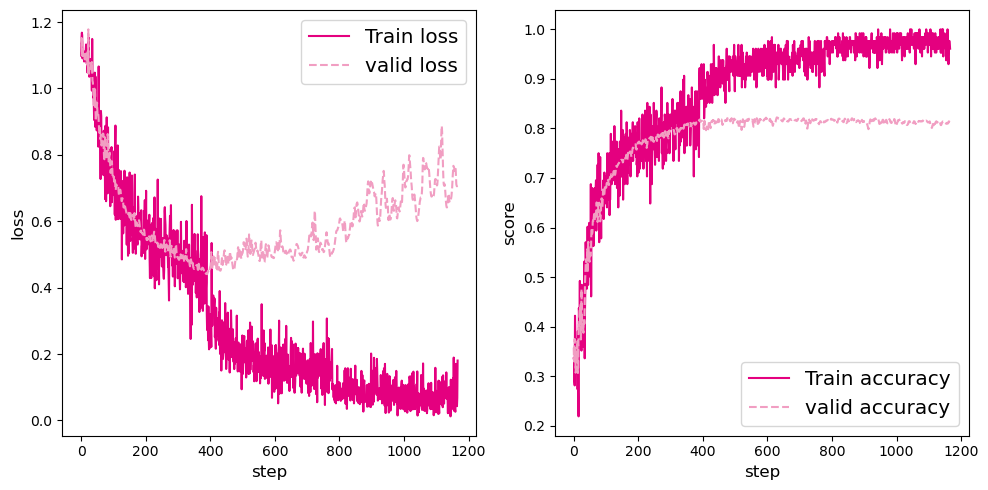

In [65]:
plot(runner,fig_name='LSTM+SelfAttention_Classifier.pdf')

In [66]:
runner.predict(test_loader)

Score on test set:0.8181322674418605


0.8181322674418605

# 5. Conclusion (5 points)

本次作业有两个部分，文本数据集无监督构建标签(Construct labels)，以及使用神经网络进行文本分类(News Classification)。
我们使用pytorch框架实现了此次任务

### Construct labels
此部分我们使用了两种方法：
1. average_word_embedding + K_means聚类
2. LDA主题模型
我们比较了两种方法的优劣，最终我们选取了LDA主题模型作为打标签的方法，同时将标签分为三类，分别对应“社会民生、文娱看点、国际时事”三种标签。

### News Classification
此部分中，我们首先完成word_embedding，利用预训练好的词向量(单词,向量)映射矩阵，建立起(单词,自然数),(自然数,word_vector)的映射。

之后在文本分类中，我们尝试了三种方法：
1. CNN方法，此方法来自一篇著名的论文"Convolutional Neural Networks for Sentence Classification",也是一个提出比较早的方法，开创性的使用一般用于图像处理中的CNN来处理文本分类问题。
2. 常规的RNN(Bi-LSTM)方法，利用双向LSTM网络，处理语句序列，最终利用LSTM隐藏层的最后状态输入到MLP中进行分类
3. Bi-LSTM + multihead-self-attention方法。首先利用LSTM处理输入序列，完成vector2vector，之后把LSTM最后一层输出的output，输入到自注意力层中，再将自注意力层的输入进行average_pooling，得到汇聚向量再输入到MLP中进行分类。

经过多次测试(结果与随机初始化相关)，三种方法在测试集上的准确率是逐步上升的，大致是从80%->81%->82%的过程。比较可知更复杂的网络可以挖掘数据的更多特征，有更加强大的学习能力。

采用Adam优化器，绘制图像可知，在第二轮epoch中即会有明显的过拟合的情况出现。网络泛化能力仍然有待提升。

### 实验中遇到的主要问题
1. 首先根本不知道有什么中文词向量可以用！后来颜航博士为我提供了一些比较优秀而且全面的数据集供我选择，我最终选择了一个“搜狗新闻”领域的词向量数据集。
2. 再就是打标签的问题，采用何种方法效果好，分为几类？都是需要考虑的。颜航博士推荐我阅读了“Sentence-Bert论文”，读完后很受启发。然而本实验并不允许使用预训练模型，而且自己也较难复现sentence-bert的训练结果，而且此方法更多的用于召回任务或者语义相似度匹配。后来，在尝试平均词向量方法效果一般后（聚类后“同一类”的新闻匪夷所思），十分沮丧。但最后在李鹏助教提示下，查阅资料了解到了LDA方法，并且在新闻学院同学的帮助下，决定采取了将新闻分为三类的方法，期待分成“社会民生、文娱看点、国际时事”，最后得到了相对合理的效果。
3. 之后遇到的问题主要是mask机制，弄得自己十分晕乎，后来仔细阅读paddle书，在舍友的帮助下基本搞懂了其实现方法。

感谢邱老师的教授，感谢李鹏助教，颜航博士，新闻学院的张宁洁同学，舍友郭虹麟在本次作业中对我的帮助！

# Reference
List your references here.

1. https://blog.csdn.net/kobeyu652453/article/details/107559519
2. https://github.com/blei-lab/lda-c
3. https://blog.csdn.net/v_july_v/article/details/41209515#t13
4. Convolutional Neural Networks for Sentence Classification https://arxiv.org/abs/1408.5882
5. https://github.com/Embedding/Chinese-Word-Vectors/blob/master/README_zh.md (词向量来源)